# Inference: Hamiltonian MCMC

This example shows you how to perform Bayesian inference on a Normal distribution and a time-series problem, using [Hamiltonian Monte Carlo](http://pints.readthedocs.io/en/latest/mcmc_samplers/hamiltonian_mcmc.html).


First, we create a simple normal distribution

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.NormalLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<Figure size 640x480 with 1 Axes>

Now we set up and run a sampling routine using Hamiltonian MCMC

In [2]:
# Choose starting points for 3 mcmc chains
xs = [
    [-5, -5],
    [3, 3],
    [18, 18],
]

# Set a standard deviation, to give the method a sense of scale
#sigma = [1, 1]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_pdf, 3, xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0.333     0.333      0:00.0
2     123    0.5       0.5       0.5        0:00.0
3     183    0.6       0.6       0.6        0:00.0
100   6003   0.98      0.98      0.98       0:00.7
200   12003  0.990099  0.990099  0.990099   0:01.4
300   18003  0.99      0.993     0.99       0:02.0
400   24003  0.993     0.993     0.993      0:02.7
500   30003  0.994     0.994     0.992      0:03.4
600   36003  0.995     0.995     0.992      0:04.1
700   42003  0.996     0.996     0.993      0:04.7
800   48003  0.996     0.996     0.994      0:05.4
900   54003  0.997     0.997     0.994      0:06.0
1000  59943  0.997003  0.997003  0.995005   0:06.7
Halting: Maximum number of iterations (1000) reached.
Done!


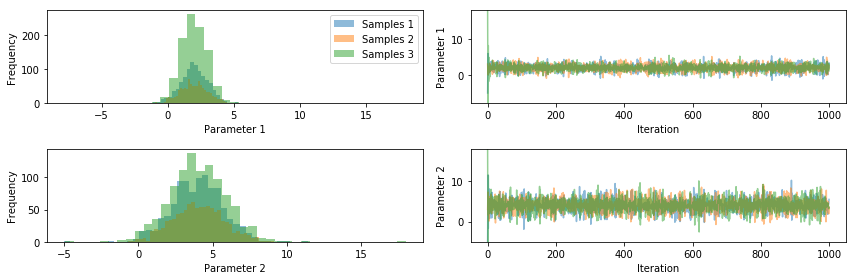

In [3]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

R-hat:
[0.9994075252761245, 0.9994561077446873]
0.004997777683528382
0.0027703382722221725
0.0074012473594478045


/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


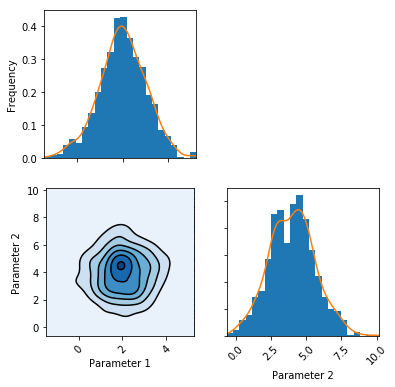

In [4]:
# Discard warm up
chains = full_chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(chains[0]))
print(log_pdf.kl_divergence(chains[1]))
print(log_pdf.kl_divergence(chains[2]))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

It seems Hamiltonian MCMC does very well at this problem!

## Hamiltonian MCMC on a time-series problem

We now try the same method on a time-series problem

First, we try it in 1d, using a wrapper around the LogisticModel to make it one-dimensional.

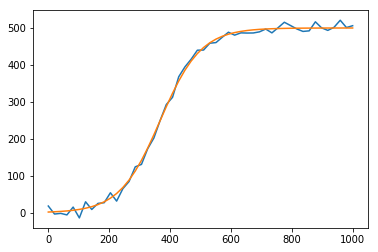

In [39]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Create a wrapper around the logistic model, turning it into a 1d model
class Model(pints.ForwardModel):
    def __init__(self):
        self.model = toy.LogisticModel()
    def simulate(self, x, times):
        return self.model.simulate([x[0], 500], times)
    def simulateS1(self, x, times):
        values, gradient = self.model.simulateS1([x[0], 500], times)
        gradient = gradient[:, 0]
        return values, gradient
    def n_parameters(self):
        return 1

# Load a forward model
model = Model()
    
# Create some toy data
real_parameters = np.array([0.015])
times = np.linspace(0, 1000, 50)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.figure()
plt.plot(times, values)
plt.plot(times, org_values)
plt.show()

We can use optimisation to find the parameter value that maximises the loglikelihood, and note that it's become slightly biased due to noise.

In [40]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

# Find the best parameters with XNES
best_parameters, fx = pints.optimise(log_likelihood, real_parameters, method=pints.XNES)
print(best_parameters[0])

Maximising LogPDF
using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 4
Iter. Eval. Best      Time m:s
0     4     -374.2353   0:00.0
1     8     -374.2353   0:00.0
2     12    -335.1027   0:00.0
3     16    -190.6176   0:00.0
20    84    -184.5913   0:00.0
40    164   -184.5911   0:00.0
60    244   -184.5911   0:00.0
80    324   -184.5911   0:00.1
100   404   -184.5911   0:00.1
120   484   -184.5911   0:00.1
140   564   -184.5911   0:00.1
160   644   -184.5911   0:00.1
180   724   -184.5911   0:00.1
200   804   -184.5911   0:00.1
220   884   -184.5911   0:00.1
240   964   -184.5911   0:00.1
249   996   -184.5911   0:00.1
Halting: No significant change for 200 iterations.
0.014993608593413373


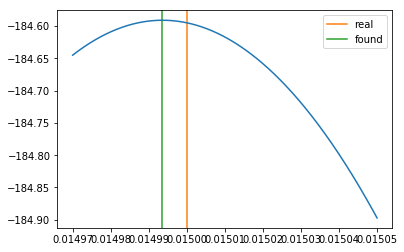

In [42]:
# Show the likelihood near the true parameters
plt.figure()
x = np.linspace(0.01497, 0.01505, 500)
y = [log_likelihood([i]) for i in x]
plt.axvline(real_parameters[0], color='tab:orange', label='real')
plt.axvline(best_parameters[0], color='tab:green', label='found')
plt.legend()
plt.plot(x, y)
plt.show()

Because the LogisticModel (and our wrapper) support the `evaluatS1()` method, we can also evaluate the gradient of the loglikelihood at different points:

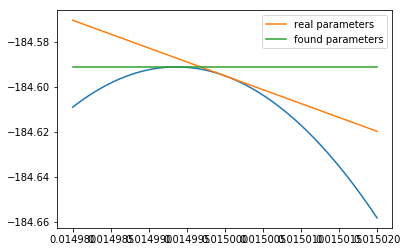

In [45]:
# Show derivatives at two points
y1, dy1 = log_likelihood.evaluateS1(real_parameters)
y2, dy2 = log_likelihood.evaluateS1(best_parameters)

# Show the likelihood near the true parameters
x = np.linspace(0.01498, 0.01502, 500)
y = [log_likelihood([i]) for i in x]
z1 = y1 + (x - real_parameters[0]) * dy1
z2 = y2 + (x - best_parameters[0]) * dy2

plt.figure()
plt.plot(x, y)
plt.plot(x, z1, label='real parameters')
plt.plot(x, z2, label='found parameters')
plt.legend()
plt.show()

Satisfied that this works, we now run a HamiltonianMCMC routine (which uses the derivative information)

In [46]:
# Choose starting points for mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Choose a covariance matrix for the proposal step
#sigma0 = (best_parameters - real_parameters) * 0.1
sigma0 = np.abs(real_parameters)

# Create mcmc routine
mcmc = pints.MCMCSampling(log_likelihood, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Set small step size
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(3e-5)   # This is very sensitive!

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0.333     0.333      0:00.0
2     123    0.5       0.5       0.5        0:00.0
3     183    0.6       0.6       0.6        0:00.0
100   6003   0.971     0.971     0.971      0:01.0
200   12003  0.985     0.970297  0.985      0:01.8
300   18003  0.986755  0.97      0.99       0:02.7
400   24003  0.983     0.975     0.99       0:03.6
500   30003  0.986     0.98      0.992      0:04.4
600   36003  0.983     0.982     0.992      0:05.2
700   42003  0.980057  0.981     0.991453   0:06.1
800   48003  0.981     0.984     0.99       0:07.0
900   54003  0.981153  0.986     0.99       0:07.9
1000  59943  0.981019  0.984016  0.99001    0:08.7
Halting: Maximum number of iterations (1000) reached.
Done!


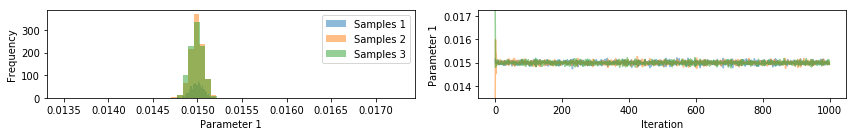

In [47]:
# Show trace and histogram
pints.plot.trace(chains)
plt.show()

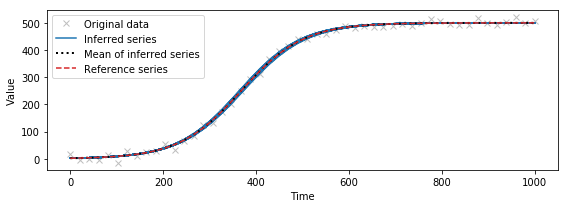

In [48]:
# Show predicted time series for the first chain
pints.plot.series(chains[0, 200:], problem, real_parameters)
plt.show()

## 2d Time series

Finally, we try Hamiltonian MCMC on a 2d logistic model problem:

In [52]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_posterior, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Set up step size
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(3.1e-5)    # This is very sensitive!

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0         0          0:00.0
2     123    0.5       0         0          0:00.0
3     183    0.4       0         0          0:00.0


/home/michael/dev/pints/pints/_mcmc/_hamiltonian.py:276: RuntimeWarning: overflow encountered in exp
  r = np.exp(current_U - proposed_U + current_K - proposed_K)


100   6003   0.225     0.0098    0.0098     0:01.6
200   12003  0.262     0.00495   0.00495    0:03.1
300   18003  0.248     0.00331   0.00331    0:04.6
400   24003  0.241     0.00249   0.00249    0:06.1
500   30003  0.237     0.00199   0.00199    0:07.6
600   36003  0.238     0.00166   0.00166    0:09.0
700   42003  0.248     0.00142   0.00142    0:10.6
800   48003  0.247     0.00125   0.00125    0:12.1
900   54003  0.242     0.00111   0.00111    0:13.8
1000  60003  0.242515  0.000998  0.000998   0:15.6
1100  66003  0.238657  0.000907  0.000907   0:17.2
1200  72003  0.248     0.000832  0.000832   0:18.7
1300  78003  0.249     0.000768  0.000768   0:20.3
1400  84003  0.25      0.000713  0.000713   0:22.3
1500  90003  0.247004  0.000666  0.000666   0:24.0
1600  96003  0.248     0.000624  0.000624   0:25.5
1700  102003  0.251     0.000588  0.000588   0:27.0
1800  108003  0.242     0.000555  0.000555   0:28.5
1900  114003  0.245     0.000526  0.000526   0:30.0
2000  119943  0.243     0.00

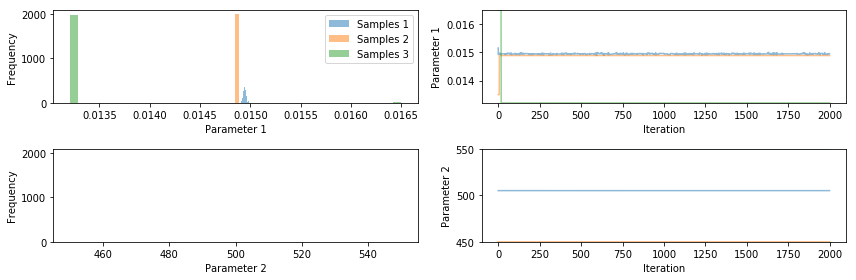

In [53]:
# Show traces and histograms
pints.plot.trace(chains)
plt.show()

It seems that, for certain starting positions, HamiltonianMCMC gets stuck and doesn't converge!